**09 November 2020**

# Topic models

## Admin

* Problem set 10 (NLP, mixed features, and regression models) due Tuesday night by 11:59pm (normal timing restored)
* Read Barron et al. for Wednesday
    * If writing a response, post to Canvas by Tuesday evening at 9:00pm
    * Three total responses due by this week
* My normal office hours (Th 9-10, F 3-4) restored

## From words to topics

* If we want to know what our documents are about -- that is, if we want to measure their content -- we can count the words in them
* Words are good, but imperfect, features, as noted in the previous lecture
    * Words split one subject or topic across multiple features
        * Example: The subject "pets" can be materialized as "cat", "kitten", "dog", "parakeet", etc.
    * Words also *fail* to split subjects that are distinct
        * Example: "fall" is a season, a physical action, and/or a state of defeat or disgrace
        * This is called *polysemy* (literally, "many signs")
    * Lemmatization helps a little with these issues, but not as much as we'd like
* We would (sometimes) like a way to replace words with subjects or topics
    * If there are fewer distinct topics than there are distinct words, we would thus trade specificity for generality
* Words -> topics would help us in two ways ...
    * Identifying topics would give us a better sense of what's in our documents
        * Related to search and information retrieval
            * How do you search if you don't know what's in your documents?
            * Or what if the documents use nonstandard language or talk around an issue?
        * It's easy to forget how often we have this problem in text analysis
        * Corpora are usually *big*; if you could read them, you wouldn't be using text mining to study them
        * *Exploratory* analysis is often warranted
    * Transforming words into topics would help with overfitting in our models by reducing the dimensionality of our feature space
        * This is a big deal, too
        * We can reduce dimensions, but the reduced version often becomes hard to interpret
        * Reduced dimensions that correspond to distinct subject matter help with explainability

## Topic models

* A topic model is any model of a corpus that has a mathematical representation of:
    * **Documents:** Containers of text that are composed from a limited number of topics
    * **Topics:** Sets of words or other tokens (or probability distributions across a vocabulary) that together are used to express a (coherent?) subject or idea
    * **Words:** Specific tokens from which topics and documents are built
* Topic models are **unsupervised**
    * This is not a classification task. We don't know in advance what are the "correct" topics, nor what words belong to which topic, nor how much of each topic is in each document.
* Topic models generally operate on word counts (so-called "bags of words"), hence do not require full, sequential texts
    * This is useful if, for some reason, you can get word counts but not full texts (copyright laws, typically)
* The earliest model that might be described as a topic model was called **Latent Semantic Analysis (LSA)**
    * In short: Truncated SVD to reduce dimensionality
        * Each dimension is a topic
    * Then examine the feature weights within each dimension
        * Feature weights tell you how much of each word is captured by each dimension
    * Each document contains some amount of each dimension
        * These are your document topic proportions
    * Can perform document similarity measurement on topic composition via the usual distance metrics (often, cosine distance)
* LSA tends to produce "diffuse" topics, since it has no mechanism to encourage sparsity
    * That is, topics contain non-trivial weights for a lot of different words
    * And documents contain nontrivial amounts of many topics
    * Good similarity performance, poor interpretability
* Now, we generally use **Latent Dirichlet Allocation (LDA)** to produce **probabilistic topic models**
    * The Dirichlet distribution allows us to parameterize "*concentration*", that is, the degree to which the topical distribution in each document is expected to be sparse
    * Topical sparsity has big advantages when it comes to interpretability
    * See today's reading for the mathematical details
        * The math isn't super hard, but it's also not our immediate concern

## The standard model of LDA

Or, where do baby documents come from?

We need a data-generating process that we can model. So, imagine we're a decent programmer and terrible fiction writer. How would we write a book?

[Hand sketch ...]

* Note that **no one thinks writers work this way** (except maybe for language poets)
* A model doesn't have to be correct to be useful

## LDA in `sklearn`

* There are lots of topic modeling packages, each of which implements some shared features and many of which introduce advanced variations (topics over time, authorless models, semi-supervised topics, etc.)
* MALLET is one of the oldest and best topic modeling packages
    * Maintained by David Mimno in Cornell IS!
    * But it's in Java
        * Java is fine, but a pain to use alongide Python
    * Check out Prof. Mimno's [online topic modeling tool](https://mimno.infosci.cornell.edu/jsLDA/)
* We'll use scikit-learn, since it integrates so seamlessly with our other workflows
    * Adequately(?) fast, decent performance, lacks bells and whistles

## Preprocessing really matters

* LDA topic models are very sensitive to preprocessing decisions
* Chunking and stopword removal are especially important
* Remember, the algorithm doesn't have a human "concept" of a topic
    * Is a topic a specific idea? A way of speaking? A high-level theme? A genre of literature?
        * The algorithm doesn't know!
* The Dirichlet distribution "wants" to produce sparse topics
    * If you use long documents that are "about" a lot of different things, your topics will be diffuse and "smear-y"
    * If your documents are short and focused on one or two ideas, your topics will be cleaner and more interpretable
        * Congressional policy speeches or press releases are good examples of whole documents that focus on one or two topics
    * In many cases, chunking by paragraph, page, or several-hundred-word passage is appropriate
    * But aggressive chunking can produce very large matrices, even in modest corpora
        * May need streaming approaches with online updates to manage memory consumption
* LDA doesn't need word order, so is well suited to "non-consumptive" or "non-expressive" use
    * Sources: [HTRC extracted features](https://analytics.hathitrust.org/datasets), [JSTOR DfR](http://www.jstor.org/dfr)
    * Hence usable with in-copyright texts that are only available as bags of words
    * Preprocessing can be trickier with these, because you do not control tokenization or chunking
    
## The US State of the Union (SOTU) address, 1791-2018

* An annual address by the president of the US to congress
* Describes political issues, priorities, and programs
* Corpus contains 227 speeches, total of about 1.75M words
* A now-classic demo for topic models

In [1]:
from   glob import glob
import os

# Where's the data?
corpus_dir = os.path.join('..', 'data', 'sotu')
files = glob(os.path.join(corpus_dir, '*.txt'))

# Read files and chunk by paragraphs
texts = []
years = []
for file in files:
    metadata = os.path.basename(file).split('.')[0]
    year = int(metadata.split('_')[1]) # file names are President_Year.txt
    with open(file, 'r') as f:
        text = f.read()
        for paragraph in text.split('\n\n'): # Paragraph break is two newlines
            texts.append(paragraph)
            years.append(year)
print("Number of SOTU texts:", len(files))
print("Number of paragraphs:", len(texts))

Number of SOTU texts: 227
Number of paragraphs: 21143


In [2]:
# Vectorize
from   sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words='english',
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.5    # Ditto
)

X = vectorizer.fit_transform(texts)
print("Feature matrix shape:", X.shape)

Feature matrix shape: (21143, 4922)


In [3]:
%%time
from   sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 1.79 s, sys: 378 ms, total: 2.17 s
Wall time: 1min 28s


LatentDirichletAllocation(evaluate_every=0, n_components=20, n_jobs=-1,
                          verbose=1)

In [4]:
# From the sklearn docs
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [5]:
print_top_words(lda, vectorizer.get_feature_names(), n_top_words=10)

Topic 0: government states united great treaty minister relations britain american british
Topic 1: public government money banks bank currency national country treasury gold
Topic 2: congress report secretary department attention service navy war consideration subject
Topic 3: nations united states foreign international relations peace policy powers american
Topic 4: world people nation peace america freedom free great country war
Topic 5: states government constitution people state union power united shall congress
Topic 6: country tariff labor business trade foreign products industry revenue duties
Topic 7: citizens states government united war property country mexico laws rights
Topic 8: united states congress treaty act convention government commission vessels session
Topic 9: economic world new development resources war trade defense production energy
Topic 10: tax year budget years billion million dollars percent income government
Topic 11: power military war forces troops use e

In [6]:
# Install pyLDAvis
#  Uncomment to run
#!conda install -c conda-forge pyldavis -y

In [7]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne', sort_topics=False)

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0      -10.878068   10.538728       1        1  6.267284
1      -60.884026  -75.591820       2        1  5.482385
2       -2.336119  -53.289074       3        1  7.958951
3      -61.385319  -12.914634       4        1  4.718187
4      -28.737743  126.296997       5        1  7.718565
5        1.066606 -123.552811       6        1  5.437673
6       45.140720   -7.947869       7        1  5.744789
7     -140.795975  -98.530548       8        1  6.036795
8       61.531681  -83.240562       9        1  5.086861
9      -72.563057 -140.396881      10        1  4.510028
10      15.984491   63.578186      11        1  3.566921
11    -160.851624   68.945145      12        1  2.647413
12      85.961830   51.922935      13        1  2.394322
13     -99.020836  109.936348      14        1  2.932068
14    -176.764130   -8.681684      15        1  6.444912
15    -117.189880  -37.420200      16        1  6.840560
16     108.829918  -22.946203      17        1  4.348414
17      47.588097  121.934814      18        1  2.268949
18    -106.467834   30.176889      19        1  3.968258
19     -50.613804   59.328842      20        1  5.626664, topic_info=            Term         Freq        Total Category  logprob  loglift
1            000  2868.000000  2868.000000  Default  30.0000  30.0000
1068    congress  4947.000000  4947.000000  Default  29.0000  29.0000
4910        year  3926.000000  3926.000000  Default  28.0000  28.0000
4288      states  6459.000000  6459.000000  Default  27.0000  27.0000
4699      united  4782.000000  4782.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
3211        paid   185.265760   498.276783  Topic20  -5.3665   1.8883
1373  department   205.127946  1351.523321  Topic20  -5.2647   0.9923
4062   secretary   199.195569  1016.683024  Topic20  -5.2940   1.2476
2193  government   227.906815  7046.238584  Topic20  -5.1594  -0.5537
4912       years   189.189723  2279.016957  Topic20  -5.3456   0.3889

[1325 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0        20  0.991723     00
1         2  0.000349    000
1        11  0.022315    000
1        16  0.001743    000
1        18  0.021967    000
...     ...       ...    ...
4918     13  0.017248  young
4918     14  0.021560  young
4918     16  0.728718  young
4918     17  0.103487  young
4918     18  0.038807  young

[6056 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [8]:
# Create a doc-topic matrix
doc_topic_matrix = lda.transform(X)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

Doc-topic matrix shape: (21143, 20)


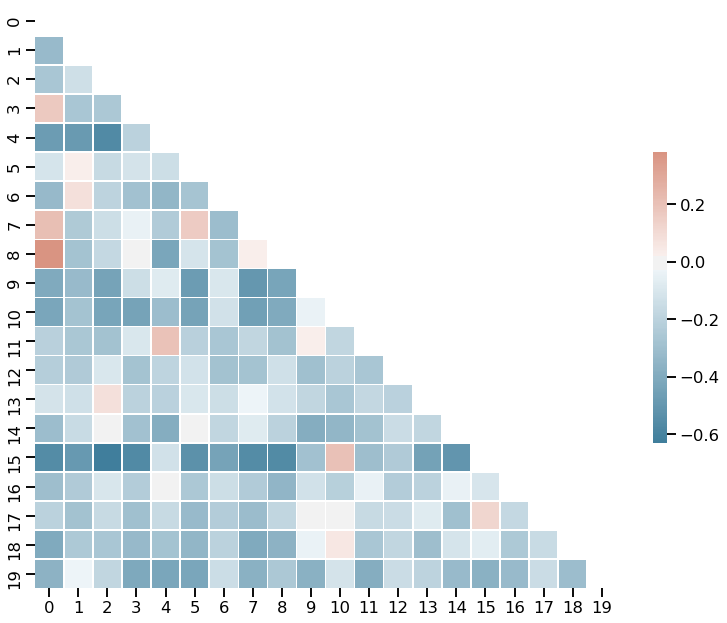

In [9]:
# Correlation plot
#  Adapted from Seaborn docs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from   sklearn.preprocessing import StandardScaler

sns.set_context('talk')
corr = np.corrcoef(doc_topic_matrix.T)

corr_std = StandardScaler().fit_transform(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_std, 
    mask=mask, 
    cmap=cmap, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.tight_layout()
plt.show()

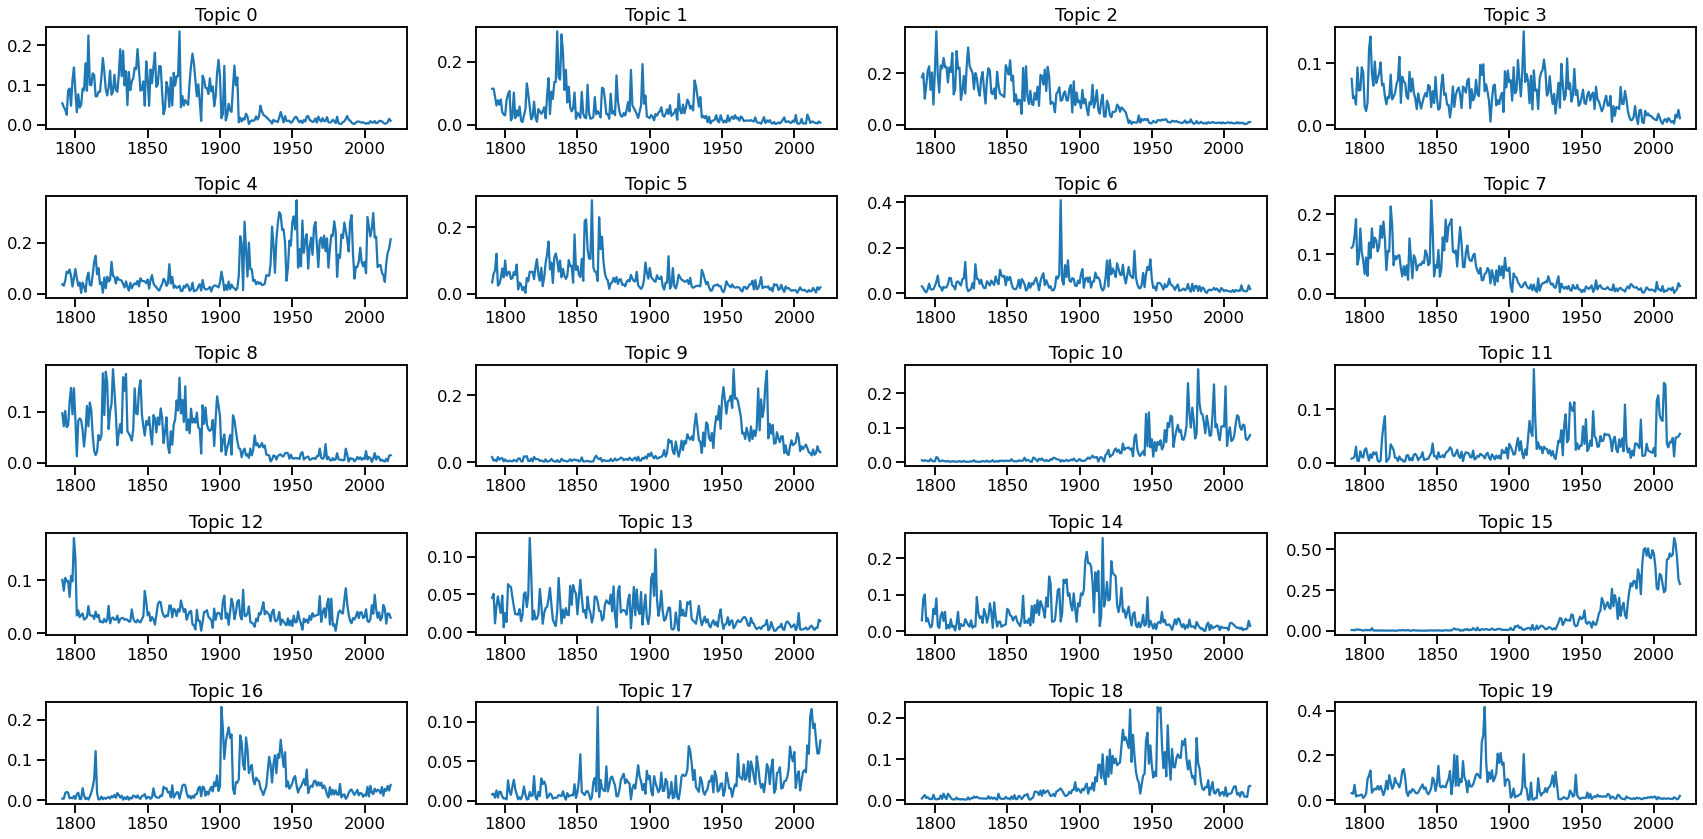

In [10]:
# Time series
n_cols = 4
n_topics = doc_topic_matrix.shape[1]
n_rows = n_topics/n_cols
if n_rows%1!=0:
    n_rows += 1
n_rows = int(n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(24,12))
axs = axs.ravel()

valid_years = sorted(np.unique(years))
for topic in range(n_topics):
    topic_data = doc_topic_matrix[:,topic]
    topic_means = []
    for year in valid_years:
        mask = np.equal(years, year)
        topic_mean = np.mean(topic_data[mask])
        topic_means.append(topic_mean)
    axs[topic].plot(valid_years, topic_means)
    axs[topic].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

Note the strong temporal trends in topic frequency. Maybe we can predict speech date from topical content?

Mean cross-validated R^2: 0.6076935398009173


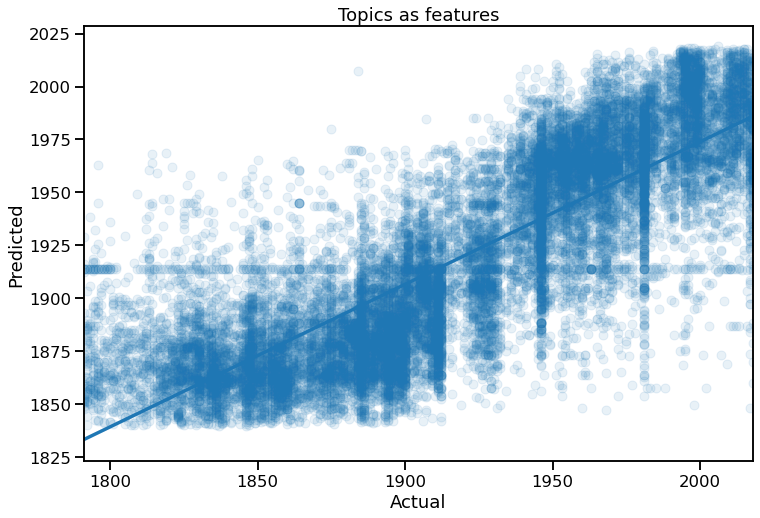

In [11]:
# Predict speech date from topic content
from   sklearn.linear_model import LinearRegression
from   sklearn.model_selection import cross_val_score

# Fit and predict using topics
X_topics = StandardScaler().fit_transform(doc_topic_matrix)
predictor = LinearRegression().fit(X_topics, years)
y_pred = predictor.predict(X_topics)

# Score
print("Mean cross-validated R^2:", np.mean(cross_val_score(LinearRegression(), X_topics, years, scoring='r2', cv=10)))

# Plot
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(years, y_pred, scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Topics as features")
plt.show()

In [12]:
%%time
# Ditto, using 20 best word features
from   sklearn.feature_selection import SelectKBest, mutual_info_regression

# Select best word features
selector = SelectKBest(mutual_info_regression, k=20)
X_words = selector.fit_transform(X, years)

# Score
print("Mean cross-validated R^2:", np.mean(cross_val_score(LinearRegression(), X_words, years, scoring='r2', cv=10)))

Mean cross-validated R^2: 0.16490612681434236
CPU times: user 13min 9s, sys: 13 s, total: 13min 22s
Wall time: 13min 26s


Predicting by topics performs **much** better than predicting by the same number of "best" word features!